In [1]:
import json
import pandas as pd
from mplsoccer import Pitch
from radar import Radar
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
detections = {'frame_id': [], 'bbox': [], 'confidence': [], 'class_id': []}
with open('detections.json', 'r') as f:
    data = json.load(f)

for frame in data:
    detections['frame_id'].append(frame['frame_id'])
    detections['bbox'].append(frame['bbox'])
    detections['confidence'].append(frame['confidence'])
    detections['class_id'].append(frame['class_id'])

In [3]:
with open('keypoints.json', 'r') as f:
    keypoints_data = json.load(f)

In [4]:
keypoints = {'frame_id': [], 'keypoints': []}
for frame in keypoints_data:
    keypoints['frame_id'].append(frame['frame_id'])
    keypoints['keypoints'].append(frame['keypoints']) 

In [5]:
player_positions: pd.DataFrame = pd.read_csv('positions_valid_021.csv')

In [11]:
player_positions

,frame,track_id,x,y,team
0,1,1,28.666695,8.431301,0
1,1,2,54.177563,10.422185,1
2,1,3,34.421994,37.107522,0
3,1,4,73.594478,34.074165,1
4,1,5,72.897025,41.929613,1
...,...,...,...,...,...
11604,750,186,64.636321,40.563977,0
11605,750,250,52.851868,4.986941,0
11606,750,187,87.517303,47.956335,0
11607,750,192,23.664182,18.029772,0


In [21]:
detections['class_id'][1]

[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0]

In [48]:
frame_mask = [True if x == 0 else False for x in detections['class_id'][1]]

In [23]:
frame_mask

[True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True]

In [49]:
player_positions_first_frame = player_positions[player_positions['frame'] == 2]

In [40]:
player_positions_first_frame

,frame,track_id,x,y,team
17,2,1,28.393654,8.519980,0
18,2,2,54.194970,10.355383,1
19,2,3,34.040185,37.347190,0
20,2,4,73.909428,33.926558,1
21,2,5,73.345672,41.892614,1
22,2,7,65.009710,14.654892,1
23,2,6,45.952678,23.574324,0
24,2,10,53.462393,0.316886,1
25,2,8,26.172024,27.158103,0
26,2,9,36.839993,53.805182,0


In [50]:
player_positions_first_frame_masked = player_positions_first_frame[frame_mask]

In [42]:
player_positions_first_frame_masked

,frame,track_id,x,y,team
17,2,1,28.393654,8.519980,0
18,2,2,54.194970,10.355383,1
19,2,3,34.040185,37.347190,0
20,2,4,73.909428,33.926558,1
21,2,5,73.345672,41.892614,1
23,2,6,45.952678,23.574324,0
24,2,10,53.462393,0.316886,1
25,2,8,26.172024,27.158103,0
26,2,9,36.839993,53.805182,0
27,2,11,9.208623,53.382854,0


<Figure size 800x800 with 0 Axes>

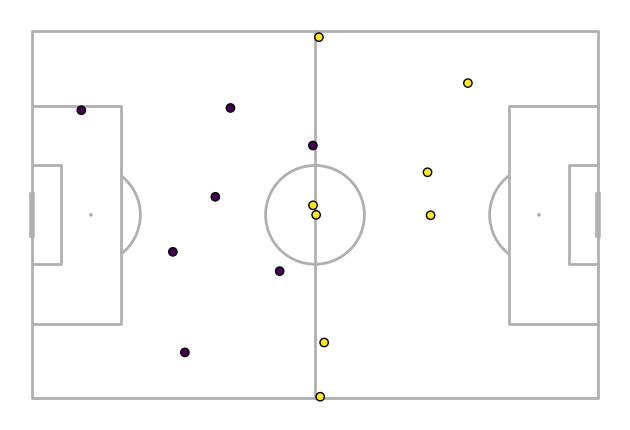

In [51]:
plt.figure(figsize=(8, 8))
pitch = Pitch(pitch_type='custom', pitch_length=105, pitch_width=68)
fig, ax = pitch.draw()
fig.patch.set_alpha(0)
ax.set_facecolor((0,0,0,0))
df = player_positions_first_frame_masked
pitch_plot = pitch.scatter(df.x, df.y, ax=ax, c=df.team, marker='o', edgecolors='black')
plt.show()

In [52]:
fig.canvas.draw()
w,h = fig.canvas.get_width_height()
img = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
img = img.reshape(h, w, 4)
img = np.roll(img, -1, axis=2)

In [53]:
first_frame = cv2.imread('data/SoccerNetGS/gamestate-2024/valid/SNGS-021/img1/000001.jpg')
frame_height, frame_width, _ = first_frame.shape

In [71]:
frame_height, frame_width

(1080, 1920)

In [54]:
overlay_resized = cv2.resize(img, (frame_width // 3, frame_height // 3))
overlay_height, overlay_width, _ = overlay_resized.shape

frame_with_overlay = first_frame.copy()

start_y = frame_height - overlay_height
start_x = (frame_width - overlay_width) // 2 
end_y = frame_height
end_x = start_x + overlay_width

pitch_alpha = overlay_resized[..., 3] / 255.0
for c in range(3):
    frame_with_overlay[start_y:end_y, start_x:end_x, c] = (
        pitch_alpha * overlay_resized[..., c] +
        (1 - pitch_alpha) * frame_with_overlay[start_y:end_y, start_x:end_x, c]
)
cv2.imshow('Frame with Pitch', frame_with_overlay)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [126]:
overlay_bgr = overlay_resized[..., :3]  
overlay_alpha = overlay_resized[..., 3] / 255.0  

start_y = frame_with_overlay.shape[0] - overlay_bgr.shape[0]
start_x = (frame_with_overlay.shape[1] - overlay_bgr.shape[1]) // 2

end_y = start_y + overlay_bgr.shape[0]
end_x = start_x + overlay_bgr.shape[1]

for c in range(3):
    frame_with_overlay[start_y:end_y, start_x:end_x, c] = (
        overlay_alpha * overlay_bgr[..., c] + 
        (1 - overlay_alpha) * frame_with_overlay[start_y:end_y, start_x:end_x, c]
    ).astype(np.uint8)

cv2.imshow('Frame with Pitch', frame_with_overlay)
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imwrite('frame_with_radar.jpg', frame_with_overlay)


True

In [128]:
player_positions[player_positions['track_id'] == 1]

,frame,track_id,x,y,team
0,1,1,28.666695,8.431301,0
17,2,1,28.393654,8.519980,0
34,3,1,28.598199,8.436447,0
51,4,1,28.680965,8.406194,0
68,5,1,28.511615,8.575993,0
...,...,...,...,...,...
2865,169,1,28.636950,6.162529,0
2881,170,1,28.351227,6.216261,0
2898,171,1,27.973599,6.221111,0
2914,172,1,27.418526,8.147218,0


In [7]:
radar = Radar(player_positions)
position_smoothed = radar.apply_savgol_filter()

In [8]:
position_n_frames = position_smoothed[position_smoothed['frame'] < 400]

In [9]:
position_n_frames

,frame,track_id,x,y,team,x_smooth,y_smooth
0,1,1,28.666695,8.431301,0,28.587025,8.469652
1,1,2,54.177563,10.422185,1,54.197634,10.404359
2,1,3,34.421994,37.107522,0,34.336429,37.171694
3,1,4,73.594478,34.074165,1,73.728749,34.012742
4,1,5,72.897025,41.929613,1,73.042742,41.903894
...,...,...,...,...,...,...,...
5946,399,188,56.448615,67.321622,1,56.881583,67.481254
5947,399,210,-2.486861,38.934514,1,-2.459600,39.252872
5948,399,116,28.757776,12.993643,0,28.777334,13.116426
5949,399,238,29.245783,-0.415881,1,29.245783,-0.415881


In [135]:
player_positions[player_positions['frame'] == 89]

,frame,track_id,x,y,team
1496,89,2,55.958384,10.371977,1
1497,89,6,49.310504,23.265478,0
1498,89,7,68.635931,21.308240,1
1499,89,3,38.192133,36.726503,0
1500,89,9,42.559792,52.809503,0
1501,89,1,31.254438,8.478437,0
1502,89,12,55.433531,45.959543,0
1503,89,10,55.219702,0.564571,1
1504,89,11,14.690541,52.401479,0
1505,89,8,32.362469,26.410581,0


<Figure size 800x800 with 0 Axes>

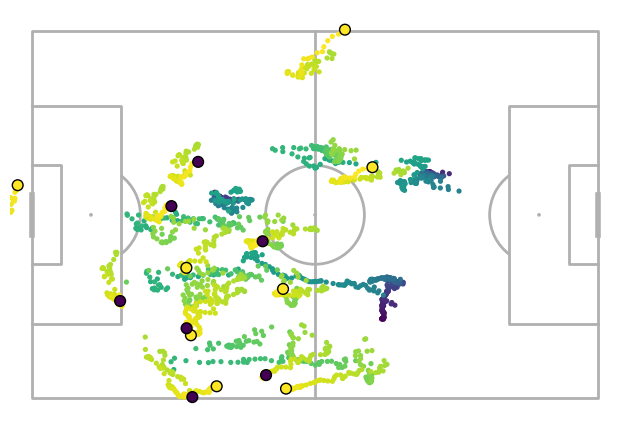

In [43]:
plt.figure(figsize=(8, 8))
pitch = Pitch(pitch_type='custom', pitch_length=105, pitch_width=68)
fig, ax = pitch.draw()
fig.patch.set_alpha(0)
ax.set_facecolor((0,0,0,0))
df = player_positions[player_positions['frame'] == 400]
track_ids = df['track_id'].unique()
position_n_frames_filtered = position_n_frames[position_n_frames['track_id'].isin(track_ids)]
pitch.scatter(position_n_frames_filtered.x_smooth, position_n_frames_filtered.y_smooth, ax=ax, c=position_n_frames_filtered.frame, marker='.', s=30)
pitch_plot = pitch.scatter(df.x, df.y, ax=ax, c=df.team, marker='o', edgecolors='black', s=60)
plt.show()

In [93]:
# add ticks for given player track id (also plot track id, maybee) and then adds tracks for last idk 60 frames so 2 secs or just specify it
def draw_trace(df: pd.DataFrame, n_frame: int, n_frames_back: int = 30, draw: bool = True) -> tuple:
    last_frame: int = n_frame - n_frames_back if n_frame - n_frames_back > 0 else 0
    df_frame = df[df['frame'] == n_frame]
    track_ids = df_frame['track_id'].unique()
    df_range = df[df['frame'].isin(range(last_frame, n_frame+1))]
    df_filtered = df_range[df_range['track_id'].isin(track_ids)]
    
    plt.figure(figsize=(8, 8))
    pitch = Pitch(pitch_type='custom', pitch_length=105, pitch_width=68)
    fig, ax = pitch.draw()
    fig.patch.set_alpha(0)
    ax.set_facecolor((0,0,0,0))
    for track_id in track_ids:
        df_track = df_range[df_range['track_id'] == track_id]
        pitch.plot(df_track.x_smooth, df_track.y_smooth, ax=ax)
    # pitch.scatter(df_filtered.x_smooth, df_filtered.y_smooth, ax=ax, c=df_filtered.frame, marker='.', s=30)
    pitch.scatter(df_frame.x_smooth, df_frame.y_smooth, ax=ax, c=df_frame.team, marker='o', edgecolors='black', s=45)
    if draw:
        plt.show()
    return fig, ax

<Figure size 800x800 with 0 Axes>

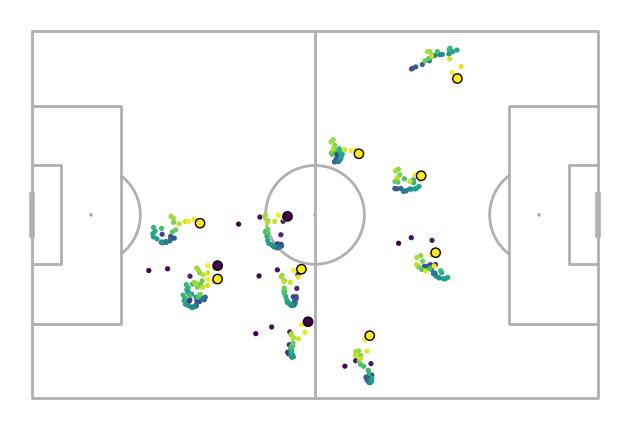

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [84]:
draw_trace(position_smoothed, 339, 30)

<Figure size 800x800 with 0 Axes>

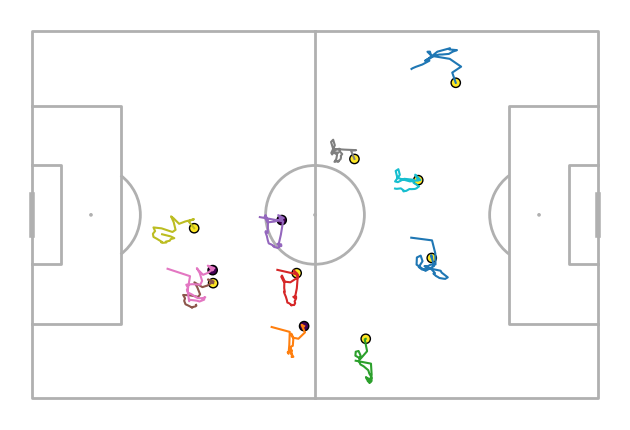

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [94]:
draw_trace(position_smoothed, 340, 30)

In [65]:
def get_frame_with_radar(frame: np.array, path: str, fig, show: bool = False) -> None:
    frame_height, frame_width, _ = frame.shape
    fig.canvas.draw()
    radar_w, radar_h = fig.canvas.get_width_height()
    img = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
    img = img.reshape(radar_h, radar_w, 4)
    img = np.roll(img, -1, axis=2) 
    overlay_resized = cv2.resize(img, (frame_width // 3, frame_height // 3))
    overlay_height, overlay_width, _ = overlay_resized.shape
    
    frame_with_overlay = frame.copy()
    
    start_y = frame_height - overlay_height
    start_x = (frame_width - overlay_width) // 2 
    end_y = frame_height
    end_x = start_x + overlay_width
    
    pitch_alpha = overlay_resized[..., 3] / 255.0
    for c in range(3):
        frame_with_overlay[start_y:end_y, start_x:end_x, c] = (
            pitch_alpha * overlay_resized[..., c] +
            (1 - pitch_alpha) * frame_with_overlay[start_y:end_y, start_x:end_x, c]
    )
    if show:
        cv2.imshow('Frame with Pitch', frame_with_overlay)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    cv2.imwrite(path, frame_with_overlay)

<Figure size 800x800 with 0 Axes>

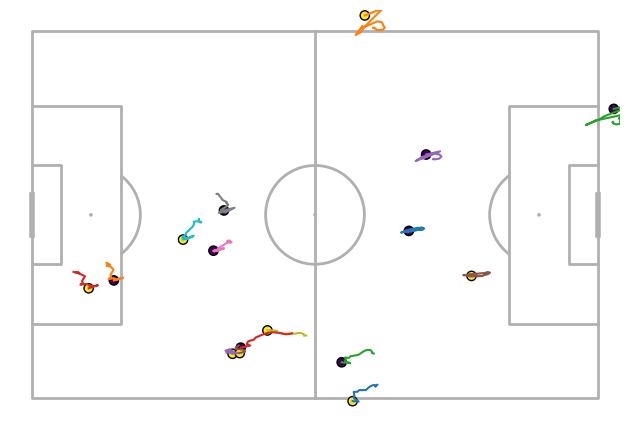

In [99]:
fig, _ = draw_trace(position_smoothed, 700, 15, False)
frame = cv2.imread('data/SoccerNetGS/gamestate-2024/valid/SNGS-021/img1/000340.jpg')
get_frame_with_radar(frame, 'first_with_radar.png', fig)